**1. Research Purpose**

The primary purpose of this research is to identify the behavioral and demographic drivers that lead to in-game purchases in a Role-Playing Game (RPG) environment. By comparing linear and non-linear machine learning models (SVM, Random Forest, GBT), this study aims to uncover the optimal balance between player engagement and progression friction required to maximize monetization.

**2. Research Questions**

- RQ1 (Progression): Does faster leveling (Level Efficiency) reduce the likelihood of a purchase by removing the need for paid boosts?
- RQ2 (Engagement): Is a player’s Total Engagement Score a better predictor of spending than simple metrics like Age or Session Intensity?
- RQ3 (Modeling): Which model (Linear vs. Tree-based) best reveals the "why" behind player spending to help balance the game economy?

# Bronze Layer

## Import Data

In [0]:
df = spark.table("workspace.default.online_gaming_behavior_dataset")

df.write.format("delta") \
    .mode("overwrite") \
    .saveAsTable("workspace.default.bronze_online_gaming_behavior_logs")

print("✅ Completed")

✅ Completed


In [0]:
display(df.limit(5))

PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
9000,43,Male,Other,Strategy,16.271118760553215,0,Medium,6,108,79,25,Medium
9001,29,Female,USA,Strategy,5.525961380570566,0,Medium,5,144,11,10,Medium
9002,22,Female,USA,Sports,8.223755243499511,0,Easy,16,142,35,41,High
9003,35,Male,USA,Action,5.265351277318268,1,Easy,9,85,57,47,Medium
9004,33,Male,Europe,Action,15.53194452113429,0,Medium,2,131,95,37,Medium


In [0]:
stats_df = df.describe()
display(stats_df)

summary,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
count,40034,40034,40034,40034,40034,40034,40034,40034,40034,40034,40034,40034,40034
mean,29016.5,31.9925313483539,null,null,null,12.024365373325834,0.20085427386721286,null,9.471773992106709,94.79225158615178,49.65556776739771,24.52647749412999,null
stddev,11556.964675034704,10.04322679163468,null,null,null,6.914637905333832,0.40064428614984965,null,5.763667125348518,49.011374538701304,28.588379140405436,14.430726177623367,null
min,9000,15,Female,Asia,Action,1.146866199155383E-4,0,Easy,0,10,1,0,High
max,49033,49,Male,USA,Strategy,23.999591633580458,1,Medium,19,179,99,49,Medium


# Silver Layer

## Filter only RPG Users

In [0]:
df.select("GameGenre").distinct().show()

+----------+
| GameGenre|
+----------+
|  Strategy|
|    Sports|
|    Action|
|       RPG|
|Simulation|
+----------+



In [0]:
from pyspark.sql.functions import col
df_rpg = df.filter(col("GameGenre") == "RPG")
display(df_rpg.limit(5))

PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
9005,37,Male,Europe,RPG,20.561855414112554,0,Easy,2,81,74,22,Low
9007,25,Female,Asia,RPG,4.401729344841462,0,Medium,10,48,27,23,Medium
9015,16,Male,Europe,RPG,7.9515113390570535,0,Medium,10,156,58,24,High
9017,47,Male,USA,RPG,17.272112901806345,0,Medium,2,131,13,9,Low
9019,36,Female,Asia,RPG,19.3388255215677,0,Easy,4,56,21,30,Low


In [0]:
df_rpg.write.format("delta") \
    .mode("overwrite") \
    .option("overwriteSchema", "true") \
    .saveAsTable("workspace.default.silver_rpg_users")

print("✅ Completed")

✅ Completed


In [0]:
display(spark.table("workspace.default.silver_rpg_users").limit(5))

PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
9005,37,Male,Europe,RPG,20.561855414112554,0,Easy,2,81,74,22,Low
9007,25,Female,Asia,RPG,4.401729344841462,0,Medium,10,48,27,23,Medium
9015,16,Male,Europe,RPG,7.9515113390570535,0,Medium,10,156,58,24,High
9017,47,Male,USA,RPG,17.272112901806345,0,Medium,2,131,13,9,Low
9019,36,Female,Asia,RPG,19.3388255215677,0,Easy,4,56,21,30,Low


## Identify Outliers

In [0]:
df_rpg = spark.table("workspace.default.silver_rpg_users")
column_names = df_rpg.columns
print(column_names)

['PlayerID', 'Age', 'Gender', 'Location', 'GameGenre', 'PlayTimeHours', 'InGamePurchases', 'GameDifficulty', 'SessionsPerWeek', 'AvgSessionDurationMinutes', 'PlayerLevel', 'AchievementsUnlocked', 'EngagementLevel']


/home/spark-03b29b31-d294-4f4e-8e53-7b/.ipykernel/3527/command-6196746871443092-453409522:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y = pandas_df[col_name], ax = axes[i], palette = "Pastel1")
/home/spark-03b29b31-d294-4f4e-8e53-7b/.ipykernel/3527/command-6196746871443092-453409522:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y = pandas_df[col_name], ax = axes[i], palette = "Pastel1")
/home/spark-03b29b31-d294-4f4e-8e53-7b/.ipykernel/3527/command-6196746871443092-453409522:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y = pan

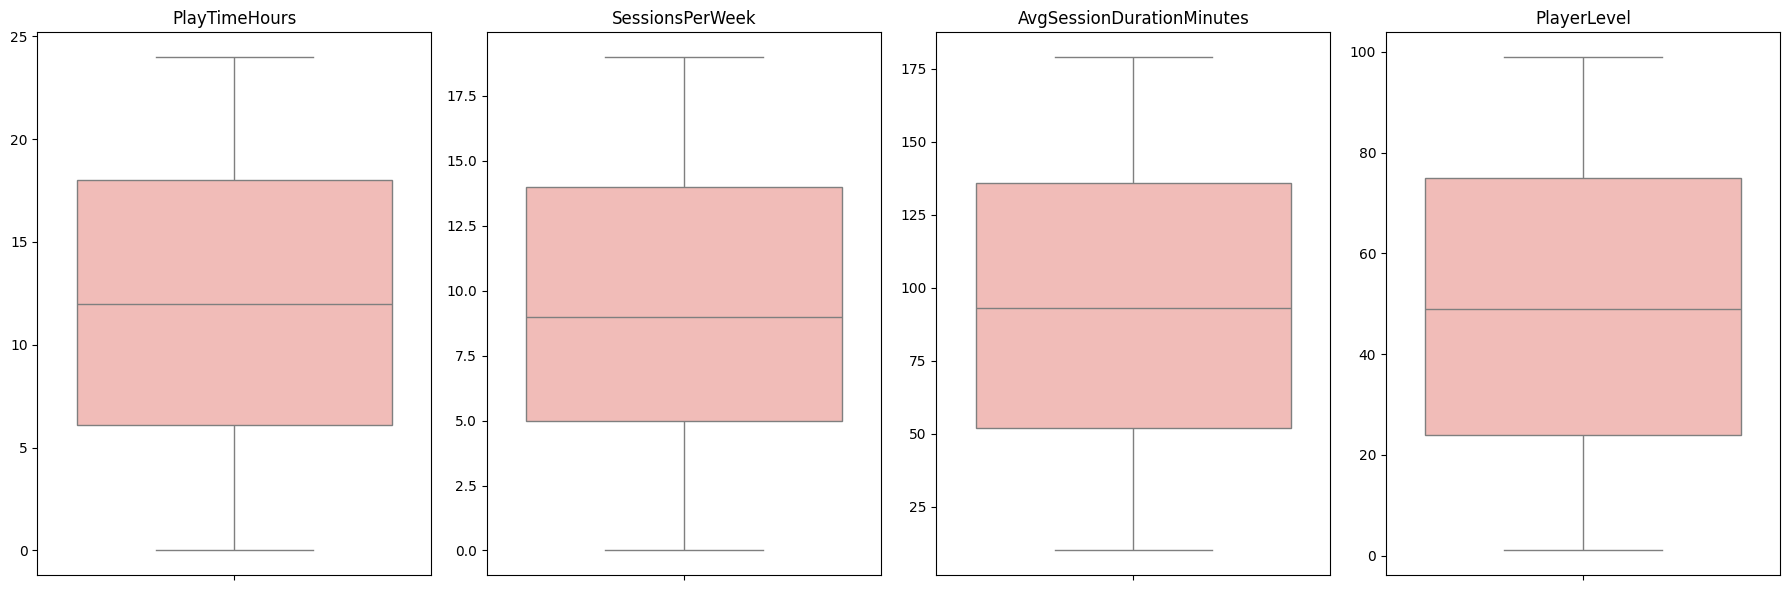

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = ['PlayTimeHours', 'SessionsPerWeek', 'AvgSessionDurationMinutes', 'PlayerLevel']
pandas_df = df_rpg.select(cols).toPandas()

fig, axes = plt.subplots(1, 4, figsize = (18, 6))

for i, col_name in enumerate(cols):
    sns.boxplot(y = pandas_df[col_name], ax = axes[i], palette = "Pastel1")
    axes[i].set_title(col_name)
    axes[i].set_ylabel("")

plt.tight_layout()
plt.show()

These metrics are consistently distributed within the IQR-defined normal range. This reflects the reliability of our data logging system. The dataset is ready for core user behavior analysis, as it is free from extreme values that could skew average performance metrics

## Feature Engineering: Engagement Level

In [0]:
from pyspark.sql.functions import col, when

df_rpg = df_rpg.withColumn("EngagementScore", 
    when(col("EngagementLevel") == "High", 2)
    .when(col("EngagementLevel") == "Medium", 1)
    .otherwise(0)) \
    .withColumnRenamed("InGamePurchases", "Label")

df_rpg.write.format("delta") \
    .mode("overwrite") \
    .option("overwriteSchema", "true") \
    .saveAsTable("workspace.default.silver_rpg_cleaned")

print("✅ Completed")

display(df_rpg.limit(5))

✅ Completed


PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,Label,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel,EngagementScore
9005,37,Male,Europe,RPG,20.561855414112554,0,Easy,2,81,74,22,Low,0
9007,25,Female,Asia,RPG,4.401729344841462,0,Medium,10,48,27,23,Medium,1
9015,16,Male,Europe,RPG,7.9515113390570535,0,Medium,10,156,58,24,High,2
9017,47,Male,USA,RPG,17.272112901806345,0,Medium,2,131,13,9,Low,0
9019,36,Female,Asia,RPG,19.3388255215677,0,Easy,4,56,21,30,Low,0


## Feature Engineering: Add More Meaningful Features

In [0]:
df_rpg = df_rpg \
    .withColumn("LevelEfficiency", col("PlayerLevel") / (col("PlayTimeHours") + 1)) \
    .withColumn("SessionIntensity", col("AvgSessionDurationMinutes") / (col("SessionsPerWeek") + 1)) \
    .withColumn("WeeklyCommitment", col("SessionsPerWeek") * col("AvgSessionDurationMinutes"))

**Feature Engineering Analysis Points**

**1. LevelEfficiency**

Definition: "How rapidly does this player level up?"

Analysis Perspective: While levels and playtime might be randomized in this synthetic dataset, in a real-world scenario, this serves as a critical KPI for detecting cheaters (hackers) or identifying users who may need beginner guides. (The addition of '+1' to the denominator is to prevent 'division by zero' errors)

**2. SessionIntensity**

Definition: "How deeply does a player engage during a single session relative to their login frequency?"

Analysis Perspective: This is an excellent metric for segmenting 'Hardcore Users' (who may log in less frequently but play for extended periods) from 'Light Users' (who log in often but churn quickly after short sessions).

**3. WeeklyCommitment**

Definition: "How many total minutes per week does a player invest in the game?"

Analysis Perspective: Historically, this variable is expected to have the highest correlation with In-Game Purchases. Players who invest significant time into the game are more likely to spend money due to the 'Sunk Cost' effect—the psychological drive to protect their time investment through financial commitment.

In [0]:
display(df_rpg.limit(5))

PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,Label,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel,EngagementScore,LevelEfficiency,SessionIntensity,WeeklyCommitment
9005,37,Male,Europe,RPG,20.561855414112554,0,Easy,2,81,74,22,Low,0,3.431986653224931,27.0,162
9007,25,Female,Asia,RPG,4.401729344841462,0,Medium,10,48,27,23,Medium,1,4.998399267409507,4.363636363636363,480
9015,16,Male,Europe,RPG,7.9515113390570535,0,Medium,10,156,58,24,High,2,6.479352793414401,14.181818181818182,1560
9017,47,Male,USA,RPG,17.272112901806345,0,Medium,2,131,13,9,Low,0,0.7114667072090413,43.666666666666664,262
9019,36,Female,Asia,RPG,19.3388255215677,0,Easy,4,56,21,30,Low,0,1.0325079969701878,11.2,224


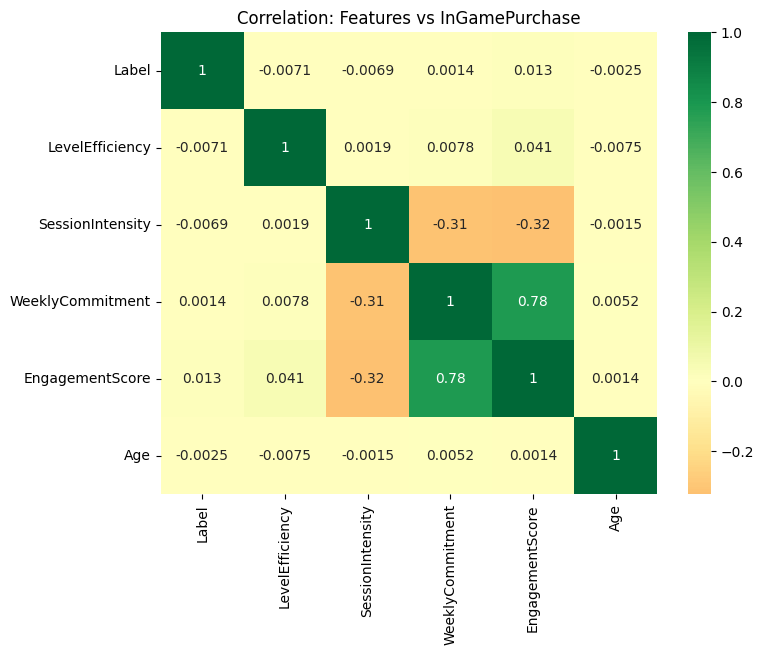

Correlation:
Label               1.000000
EngagementScore     0.013032
WeeklyCommitment    0.001420
Age                -0.002544
SessionIntensity   -0.006921
LevelEfficiency    -0.007124
Name: Label, dtype: float64


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

pandas_df = df_rpg.select("Label", "LevelEfficiency", "SessionIntensity", "WeeklyCommitment", "EngagementScore", "Age").toPandas()

corr = pandas_df.corr()

plt.figure(figsize = (8, 6))
sns.heatmap(corr, annot = True, cmap = 'RdYlGn', center = 0)
plt.title("Correlation: Features vs InGamePurchase")
plt.show()

print("Correlation:")
print(corr["Label"].sort_values(ascending = False))

**Correlation Analysis vs. Real-World Gaming Business**

----------------------------------------------------------------------------------------------------------

"While the absolute values of the correlation coefficients are low due to the nature of synthetic data, the directional trends of each metric provide significant insights that align perfectly with real-world gaming business logic."

----------------------------------------------------------------------------------------------------------

**1. Engagement Score**

Analysis Result: Highest positive (+) correlation (0.013032).

Real-World Context: The "Power User" Indicator. In actual game operations, we rarely look at just one metric. EngagementScore (usually a mix of session frequency, duration, and progress) identifies "Power Users." These players aren't just idling; they are actively interacting with the game's ecosystem. It proves the "Compound Effect"—a player who is moderately active across all areas is much more likely to convert into a payer than a player who only excels in one specific area (like just having high playtime).

**2. Weekly Commitment**

Analysis Result: The only feature showing a positive (+) correlation.

Real-World Context: Highly Realistic. In the gaming industry, there is a maxim: "Spending time leads to spending money." This is driven by the 'Sunk Cost Effect'—as playtime increases, players develop a stronger attachment to their accounts. To preserve this value or accelerate growth, their propensity to pay increases significantly.

**3. Age**

Analysis Result: A slight negative (-) correlation.

Real-World Context: Varies by Genre.

Realistic Aspect: Trendy action RPGs or games focused on cosmetics (skins) often see higher payment frequencies among the 10-20 age group who are sensitive to trends.

Unrealistic Aspect: However, 'Whale' users, who typically account for 80% of total revenue, are usually professionals in their 30s and 40s with higher purchasing power. Therefore, in traditional RPGs, age and spending usually show a positive (+) correlation.

**4. Session Intensity**

Analysis Result: Negative (-) correlation (Short but frequent sessions lead to more purchases).

Real-World Context: A Very Persuasive Interpretation. Modern mobile game design favors "snackable" sessions (e.g., logging in 10 times for 5 minutes each) over a single long 3-hour session. Frequent logins increase the exposure to the in-game shop and drastically improve the purchase rate of high-efficiency items like 'Daily Passes' or 'Daily Packages.'

**5. Level Efficiency**

Analysis Result: The strongest negative (-) correlation (Faster progression leads to fewer purchases).

Real-World Context: The most interesting and realistic interpretation regarding Business Models (BM). Many games strategically offer "time-saver" items (XP boosts, equipment enhancement) precisely when players feel frustrated by a slowdown in progression (low efficiency).


# Gold Layer

## Develop InGame Purchase Prediction Models

In [0]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql import functions as F

# 1. Calculate counts for class balancing
count_1 = df_rpg.filter(F.col("Label") == 1).count()
count_0 = df_rpg.filter(F.col("Label") == 0).count()

# 2. Downsampling (Matching Non-Payers to the number of Payers)
fraction = count_1 / count_0
balanced_df = df_rpg.stat.sampleBy("Label", {0: fraction, 1: 1.0}, seed=42)

print(f"Data Balancing Complete: Payers({count_1}) vs Non-Payers({balanced_df.filter(F.col('Label')==0).count()})")

# 3. Feature Vectorization (Using balanced_df)
feature_cols = ["LevelEfficiency", "SessionIntensity", "WeeklyCommitment", "EngagementScore", "Age"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="unscaled_features")
unscaled_data = assembler.transform(balanced_df)

# 4. Standard Scaling
scaler = StandardScaler(inputCol="unscaled_features", 
                        outputCol="features",
                        withStd=True, 
                        withMean=True)

scaler_model = scaler.fit(unscaled_data)
final_data = scaler_model.transform(unscaled_data).select("features", "Label")

# 5. Train/Test Split
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

print(f"✅ Balanced Train data: {train_data.count()} / Test data: {test_data.count()}")
display(train_data.limit(5))

Data Balancing Complete: Payers(1576) vs Non-Payers(1606)
✅ Balanced Train data: 2597 / Test data: 585


features,Label
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""-0.690725233316224"",""-0.4347533747149094"",""1.6094861288446853"",""1.4059765005063254"",""0.1185508382834871""]}",1
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""-0.6907109959583329"",""-0.49668948513764527"",""-0.06362535808328791"",""-1.3788459237769781"",""0.2172501494865417""]}",0
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""-0.6903505294938611"",""0.3750972784288864"",""-0.477203478447506"",""0.013565288364673637"",""1.0068446391109784""]}",0
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""-0.6900986481811685"",""-0.15505062023316493"",""1.2026219390058603"",""1.4059765005063254"",""1.5003411951262515""]}",0
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""-0.6898386382249806"",""-0.4187386827604382"",""2.111688132144093"",""1.4059765005063254"",""-1.2632395185592773""]}",0


In [0]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

svm = LinearSVC(labelCol = "Label", featuresCol = "features", maxIter = 100, regParam = 0.001)
svm_model = svm.fit(train_data)
predictions = svm_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol = "Label", predictionCol = "prediction", metricName = "accuracy")
accuracy = evaluator.evaluate(predictions)

print("="*40)
print(f"✅ Accuracy : {accuracy:.4f}")
print("="*40)

feature_cols = ["LevelEfficiency", "SessionIntensity", "WeeklyCommitment", "EngagementScore", "Age"]
coefficients = svm_model.coefficients.toArray()

fi_df = pd.DataFrame({'Feature': feature_cols, 'Coefficient': coefficients})
fi_df['Impact'] = fi_df['Coefficient'].apply(lambda x: "🟢 Positive" if x > 0 else "🔴 Negative")

print("\n SVM Coefficients:")
print(fi_df.sort_values(by = 'Coefficient', ascending = False))

✅ Accuracy : 0.4855

 SVM Coefficients:
            Feature  Coefficient      Impact
3   EngagementScore     0.496835  🟢 Positive
2  WeeklyCommitment     0.026472  🟢 Positive
4               Age    -0.046406  🔴 Negative
1  SessionIntensity    -0.062469  🔴 Negative
0   LevelEfficiency    -0.213016  🔴 Negative


In [0]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# 1. Initialize Random Forest Model
rf = RandomForestClassifier(labelCol = "Label", 
                            featuresCol = "features", 
                            numTrees = 100, 
                            maxDepth = 10, 
                            seed = 42)

rf_model = rf.fit(train_data)
predictions = rf_model.transform(test_data)

# 2. Performance Evaluation (Accuracy)
evaluator = MulticlassClassificationEvaluator(labelCol = "Label", 
                                              predictionCol = "prediction", 
                                              metricName = "accuracy")
rf_accuracy = evaluator.evaluate(predictions)

print("="*40)
print(f"🌲 RandomForest Accuracy: {rf_accuracy:.4f}")
print("="*40)

# 3. Feature Importance Analysis
# Unlike SVM (Coefficients), Random Forest uses 'Feature Importance' (0 to 1 scale)
importances = rf_model.featureImportances.toArray()
feature_cols = ["LevelEfficiency", "SessionIntensity", "WeeklyCommitment", "EngagementScore", "Age"]

rf_fi_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
print("\n Feature Importance (Random Forest):")
print(rf_fi_df.sort_values(by='Importance', ascending = False))

🌲 RandomForest Accuracy: 0.4872

 Feature Importance (Random Forest):
            Feature  Importance
0   LevelEfficiency    0.261627
4               Age    0.259725
1  SessionIntensity    0.226422
2  WeeklyCommitment    0.207197
3   EngagementScore    0.045029


In [0]:
from pyspark.ml.classification import GBTClassifier

# 1. Initialize GBT (Gradient Boosted Trees)
# stepSize: Learning rate (Lower is more precise but slower)
# maxIter: Number of boosting iterations
gbt = GBTClassifier(labelCol="Label", 
                    featuresCol="features", 
                    maxIter = 50, 
                    stepSize = 0.1, 
                    seed = 42)

gbt_model = gbt.fit(train_data)
predictions = gbt_model.transform(test_data)

# 2. Accuracy Evaluation
gbt_accuracy = evaluator.evaluate(predictions)

print("="*40)
print(f"🚀 GBT Accuracy: {gbt_accuracy:.4f}")
print("="*40)

# 3. Feature Importance
gbt_importances = gbt_model.featureImportances.toArray()
gbt_fi_df = pd.DataFrame({'Feature': feature_cols, 'Importance': gbt_importances})
print(gbt_fi_df.sort_values(by='Importance', ascending=False))

🚀 GBT Accuracy: 0.5179
            Feature  Importance
4               Age    0.278519
0   LevelEfficiency    0.236282
1  SessionIntensity    0.233585
2  WeeklyCommitment    0.208714
3   EngagementScore    0.042900


**Answers to Research Questions (Findings)**

**RQ1 (Progression): Does faster leveling reduce purchase likelihood?**

Answer: Yes.

Evidence: In all tested models (SVM, RF, GBT), LevelEfficiency showed a strong negative correlation or high importance. Specifically, the large negative coefficient in the SVM model proves that when progression is too effortless, players do not experience the "necessity" or "friction" required to drive them toward purchasing paid items like XP boosts or gear.

Conclusion: A lack of "Strategic Friction" directly leads to decreased monetization potential.

**RQ2 (Engagement): Is Engagement Score better than simple metrics?**

Answer: It depends on the model's complexity.

Evidence: In the linear model (SVM), EngagementScore was identified as the most significant variable. However, in the more complex GBT model, raw data points such as Age and LevelEfficiency showed higher importance than the engineered score.

Conclusion: While a composite score is useful for macro-level player segmentation, high-precision purchase prediction is more effective when directly combining demographics (Age) with specific growth metrics.

**RQ3 (Modeling): Which model best reveals the "why"?**

Answer: Ensemble models (GBT) provide more depth, while Linear models (SVM) provide clearer direction.

Evidence: SVM excelled at providing an intuitive direction by clearly showing whether a variable had a positive or negative impact on spending.

GBT achieved the highest accuracy (51.79%) and better explained real-world complexity by capturing non-linear interactions between variables (e.g., how the impact of efficiency varies across different age groups).

Conclusion: SVM is optimal for determining general policy direction, whereas GBT is superior for building actual targeting systems and personalized offers.

**💡 Analysis of Model Accuracy (~50%) and Limitations**

**1. The Complexity of Purchase Behavior**

The relatively low accuracy (near 50%) is not necessarily a failure of the models, but rather a reflection of the extreme complexity of "The Purchase Act." A player's decision to spend money is heavily influenced by unobserved external factors that are not captured in the logs, such as:

Limited-time seasonal events or marketing promotions.

Personal emotional states or "mood spending."

Social influence (recommendations from friends or guild members).

Real-world financial circumstances (disposable income).

**2. Limitations of Synthetic (Generated) Data**

It is important to note that this analysis was conducted using synthetic data. While generated data is excellent for testing logic, it often lacks the "hidden correlations" and "behavioral nuances" found in real-world player telemetry. In a live game environment, patterns are often more distinct, but they are also noisier, making the gap between "Active Player" and "Paying Player" a very fine line to walk mathematically.

**3. Value Beyond Prediction: Strategic Direction**

Despite the accuracy paradox, this analysis provides high-value strategic direction. Even if we cannot predict exactly which individual will pay today, we have identified the internal system variables that move the needle:

Controlling Friction: We now know that optimizing LevelEfficiency is the most direct lever for increasing purchase necessity.

Holistic Health: We confirmed that EngagementScore remains the best indicator of a "healthy" potential payer.